### 自动作文评估
在此项目中，我们通过文本分析技术来对一篇作为自动打分，其中核心过程在于特征工程（如何从一篇文章里提取有效的特征？）。 分数是real number, 所以在这里我们采用的时候regression setting

### 导入相关package

In [32]:
import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import re, collections, word2vec
from collections import defaultdict
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVC
from sklearn import ensemble
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import cohen_kappa_score

### 1. 读取数据

In [33]:
data = pd.read_csv('data/essays_and_scores.csv', encoding = 'latin-1')

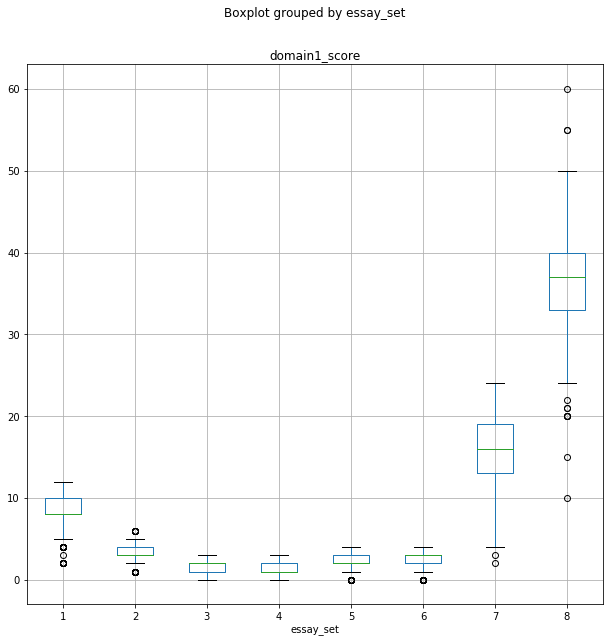

In [34]:
# 利用boxplot来可视化domain1_score的分布。 

%matplotlib inline
data.boxplot(column = 'domain1_score', by = 'essay_set', figsize = (10, 10))

### 2. 特征工程
此部分为这个项目的核心，其中几个特征的描述已经给出。

In [35]:
model = word2vec.load('essay.bin')
with open("data/words.txt","r") as f:
    word_library = set(f.readlines())


def get_embedding(essay):
    """
    对于essay, 获取embedding特征，需要用到"embedding.txt"。具体如何训练词向量，请参考另外一个python notebook
    """
    essay_list = essay.split()     # 将句子(英文)通过空格分割成由单词组成的list
    essay_vec = []    # 存储向量的矩阵
    for e in essay_list:     # 遍历所有单词，返回每个单词的向量
        e = word_del_punctuation(e)   # str处理，去除标点符号
        if e in model.vocab:
            essay_vec.append(model[e].tolist())   # model[e]是numpyarray,转成list然后存进essay_vec矩阵
    essay_vec = pd.DataFrame(essay_vec)  # 转成DataFrame格式，方便求句子的向量平均值
    if len(essay_list) > 0:
        return (essay_vec.sum() / len(essay_list)).tolist()
    else:
        print('Error')
        
def avg_word_len(essay):
    """
    文章中单词的平均长度
    """
    essay_list = essay.split()
    i = 0
    for e in essay_list:
        i += len(e)
    if len(essay_list) > 0:
        avg_len = i / (len(essay_list))
        return avg_len
    else:
        return 0
    
    
def word_count(essay):
    """
    文章中单词的总数
    """
    essay_list = essay.split()
    return len(essay_list)
    
def setence_count(essay):
    """
    文章中句子的个数
    """
    essay_list = essay.split('.')
    return len(essay_list)
    
lemmatizer = WordNetLemmatizer()
def count_spell_error(essay):
    """
    文章中有多少个单词的拼错的,需要用到词库（words.txt）
    """
    essay_list = essay.split()
    i = 0
    for e in essay_list:
        e = word_del_punctuation(e)
        if e.lower() not in word_library:
            i += 1
    return i

# def count_pos(essay):
    """
    出现了多少个名词，动词以及形容词？
    """
    
    
## 去除标点符号
def word_del_punctuation(e):
    if not e.isalpha():
        e=e.replace(',','')
        e=e.replace('.','')
        e=e.replace(':','')
        e=e.replace('!','')
        e=e.replace('?','')
        e=e.replace('/','')
        e=e.replace(';','')
        e=e.replace("'",'')
        e=e.replace('"','')

    return e

In [40]:
def extract_features(data):
    """
    对于训练集，读取所有相关的特征in one place
    """
    features = []
    for essay in data:
        if essay:
            feature = get_embedding(essay)
            feature.append(avg_word_len(essay)) 
            feature.append(word_count(essay))
            feature.append(setence_count(essay))
            feature.append(count_spell_error(essay))
            features.append(feature)
    return pd.DataFrame(features)

In [41]:
features = extract_features(data['essay'])
X = features.as_matrix()
y = data['domain1_score'].as_matrix()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

### 3 利用GBDT模型做预测
GBDT作为一个集成模型，应用场景非常广泛，也被证实确实效果不错。在此部分，我们尝试使用GBDT模型来预测essay score. 

### 3.1. 创建gbdt 模型

In [38]:
# TODO
# 定义params: 需要定义以下几个变量 n_estimators, max_depth, min_samples_split, learing_rate, loss 
#            其中loss使用'ls'
n_estimators = np.arange(50,150,10)
max_depth = [1,2,3,4,5]
min_samples_split = [2,3]
learning_rate = np.logspace(-3,2,6)
params = {'n_estimators':n_estimators, 'max_depth':max_depth, 'min_samples_split':min_samples_split, 'learning_rate':learning_rate}
gbr = ensemble.GradientBoostingRegressor(loss='ls')

### 3.2. GridSearchCV 

In [42]:
# TODO
# 使用GridSearchCV 搜索参数
grid = GridSearchCV(gbr, params, cv=5)
grid.fit(X_train, y_train)
print(grid.best_score_)
print(grid.best_estimator_.alpha)

/Users/lyn/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:285: RuntimeWarning: overflow encountered in square
  np.sum(sample_weight * ((y - pred.ravel()) ** 2.0)))
/Users/lyn/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/metrics/regression.py:463: RuntimeWarning: overflow encountered in square
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,
/Users/lyn/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:285: RuntimeWarning: overflow encountered in square
  np.sum(sample_weight * ((y - pred.ravel()) ** 2.0)))
/Users/lyn/anaconda2/envs/py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/lyn/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/metrics/regression.py:463: RuntimeWarning: overflow encountered in square
  numerator = (weight * (y_true - y_pred) ** 2).sum(axi

/Users/lyn/anaconda2/envs/py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/lyn/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:285: RuntimeWarning: overflow encountered in square
  np.sum(sample_weight * ((y - pred.ravel()) ** 2.0)))
/Users/lyn/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/metrics/regression.py:463: RuntimeWarning: overflow encountered in square
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,
/Users/lyn/anaconda2/envs/py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/lyn/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:285: RuntimeWarning: overflow encountered in square
  np.sum(sample_weight * ((y - pred.ravel()) ** 2.0)))
/

/Users/lyn/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/metrics/regression.py:463: RuntimeWarning: overflow encountered in square
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,
/Users/lyn/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:285: RuntimeWarning: overflow encountered in square
  np.sum(sample_weight * ((y - pred.ravel()) ** 2.0)))
/Users/lyn/anaconda2/envs/py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/lyn/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/metrics/regression.py:463: RuntimeWarning: overflow encountered in square
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,
/Users/lyn/anaconda2/envs/py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Use

/Users/lyn/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/metrics/regression.py:463: RuntimeWarning: overflow encountered in square
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,
/Users/lyn/anaconda2/envs/py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/lyn/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:285: RuntimeWarning: overflow encountered in square
  np.sum(sample_weight * ((y - pred.ravel()) ** 2.0)))
/Users/lyn/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/metrics/regression.py:463: RuntimeWarning: overflow encountered in square
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,
/Users/lyn/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:285: RuntimeWarning: overflow encountered in square
  np.sum(sample_weight * ((y - pred.ravel()) ** 2.

/Users/lyn/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/metrics/regression.py:463: RuntimeWarning: overflow encountered in square
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,
/Users/lyn/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:285: RuntimeWarning: overflow encountered in square
  np.sum(sample_weight * ((y - pred.ravel()) ** 2.0)))
/Users/lyn/anaconda2/envs/py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/lyn/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/metrics/regression.py:463: RuntimeWarning: overflow encountered in square
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,
/Users/lyn/anaconda2/envs/py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Use

/Users/lyn/anaconda2/envs/py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/lyn/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/metrics/regression.py:463: RuntimeWarning: overflow encountered in square
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,
/Users/lyn/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:285: RuntimeWarning: overflow encountered in square
  np.sum(sample_weight * ((y - pred.ravel()) ** 2.0)))
/Users/lyn/anaconda2/envs/py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/lyn/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/metrics/regression.py:463: RuntimeWarning: overflow encountered in square
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,
/Use

/Users/lyn/anaconda2/envs/py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/lyn/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/metrics/regression.py:463: RuntimeWarning: overflow encountered in square
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,
/Users/lyn/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:285: RuntimeWarning: overflow encountered in square
  np.sum(sample_weight * ((y - pred.ravel()) ** 2.0)))
/Users/lyn/anaconda2/envs/py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/lyn/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/metrics/regression.py:463: RuntimeWarning: overflow encountered in square
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,
/Use

/Users/lyn/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/metrics/regression.py:463: RuntimeWarning: overflow encountered in square
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,
/Users/lyn/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:285: RuntimeWarning: overflow encountered in square
  np.sum(sample_weight * ((y - pred.ravel()) ** 2.0)))
/Users/lyn/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/metrics/regression.py:463: RuntimeWarning: overflow encountered in square
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,
/Users/lyn/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:285: RuntimeWarning: overflow encountered in square
  np.sum(sample_weight * ((y - pred.ravel()) ** 2.0)))
/Users/lyn/anaconda2/envs/py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwa

/Users/lyn/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/metrics/regression.py:463: RuntimeWarning: overflow encountered in square
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,
/Users/lyn/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:285: RuntimeWarning: overflow encountered in square
  np.sum(sample_weight * ((y - pred.ravel()) ** 2.0)))
/Users/lyn/anaconda2/envs/py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/lyn/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/metrics/regression.py:463: RuntimeWarning: overflow encountered in square
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,
/Users/lyn/anaconda2/envs/py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Use

/Users/lyn/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/metrics/regression.py:463: RuntimeWarning: overflow encountered in square
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,
/Users/lyn/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:285: RuntimeWarning: overflow encountered in square
  np.sum(sample_weight * ((y - pred.ravel()) ** 2.0)))
/Users/lyn/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/metrics/regression.py:463: RuntimeWarning: overflow encountered in square
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,
/Users/lyn/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:285: RuntimeWarning: overflow encountered in square
  np.sum(sample_weight * ((y - pred.ravel()) ** 2.0)))
/Users/lyn/anaconda2/envs/py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwa

/Users/lyn/anaconda2/envs/py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/lyn/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/metrics/regression.py:463: RuntimeWarning: overflow encountered in square
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,
/Users/lyn/anaconda2/envs/py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/lyn/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:285: RuntimeWarning: overflow encountered in square
  np.sum(sample_weight * ((y - pred.ravel()) ** 2.0)))
/Users/lyn/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/metrics/regression.py:463: RuntimeWarning: overflow encountered in square
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,
/Use

/Users/lyn/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:285: RuntimeWarning: overflow encountered in square
  np.sum(sample_weight * ((y - pred.ravel()) ** 2.0)))
/Users/lyn/anaconda2/envs/py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/lyn/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/metrics/regression.py:463: RuntimeWarning: overflow encountered in square
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,
/Users/lyn/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:285: RuntimeWarning: overflow encountered in square
  np.sum(sample_weight * ((y - pred.ravel()) ** 2.0)))
/Users/lyn/anaconda2/envs/py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/

/Users/lyn/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/metrics/regression.py:463: RuntimeWarning: overflow encountered in square
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,
/Users/lyn/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:285: RuntimeWarning: overflow encountered in square
  np.sum(sample_weight * ((y - pred.ravel()) ** 2.0)))
/Users/lyn/anaconda2/envs/py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/lyn/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/metrics/regression.py:463: RuntimeWarning: overflow encountered in square
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,
/Users/lyn/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:285: RuntimeWarning: overflow encountered in square
  np.sum(sample_weight * ((y - pred.ravel()) ** 2.

/Users/lyn/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/metrics/regression.py:463: RuntimeWarning: overflow encountered in square
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,
/Users/lyn/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:285: RuntimeWarning: overflow encountered in square
  np.sum(sample_weight * ((y - pred.ravel()) ** 2.0)))
/Users/lyn/anaconda2/envs/py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/lyn/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/metrics/regression.py:463: RuntimeWarning: overflow encountered in square
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,
/Users/lyn/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:285: RuntimeWarning: overflow encountered in square
  np.sum(sample_weight * ((y - pred.ravel()) ** 2.

/Users/lyn/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:285: RuntimeWarning: overflow encountered in square
  np.sum(sample_weight * ((y - pred.ravel()) ** 2.0)))
/Users/lyn/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/metrics/regression.py:463: RuntimeWarning: overflow encountered in square
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,
/Users/lyn/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:285: RuntimeWarning: overflow encountered in square
  np.sum(sample_weight * ((y - pred.ravel()) ** 2.0)))
/Users/lyn/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/metrics/regression.py:463: RuntimeWarning: overflow encountered in square
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,
/Users/lyn/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:285: RuntimeWarning: overflow encountered in square
  np.sum(sample_weight * ((y - pred.ravel

/Users/lyn/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/metrics/regression.py:463: RuntimeWarning: overflow encountered in square
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,
/Users/lyn/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:285: RuntimeWarning: overflow encountered in square
  np.sum(sample_weight * ((y - pred.ravel()) ** 2.0)))
/Users/lyn/anaconda2/envs/py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/lyn/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/metrics/regression.py:463: RuntimeWarning: overflow encountered in square
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,
/Users/lyn/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:285: RuntimeWarning: overflow encountered in square
  np.sum(sample_weight * ((y - pred.ravel()) ** 2.

/Users/lyn/anaconda2/envs/py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/lyn/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:285: RuntimeWarning: overflow encountered in square
  np.sum(sample_weight * ((y - pred.ravel()) ** 2.0)))
/Users/lyn/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/metrics/regression.py:463: RuntimeWarning: overflow encountered in square
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,
/Users/lyn/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:285: RuntimeWarning: overflow encountered in square
  np.sum(sample_weight * ((y - pred.ravel()) ** 2.0)))
/Users/lyn/anaconda2/envs/py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/

/Users/lyn/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:285: RuntimeWarning: overflow encountered in square
  np.sum(sample_weight * ((y - pred.ravel()) ** 2.0)))
/Users/lyn/anaconda2/envs/py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/lyn/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/metrics/regression.py:463: RuntimeWarning: overflow encountered in square
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,
/Users/lyn/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:285: RuntimeWarning: overflow encountered in square
  np.sum(sample_weight * ((y - pred.ravel()) ** 2.0)))
/Users/lyn/anaconda2/envs/py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/

/Users/lyn/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/metrics/regression.py:463: RuntimeWarning: overflow encountered in square
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,
/Users/lyn/anaconda2/envs/py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/lyn/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:285: RuntimeWarning: overflow encountered in square
  np.sum(sample_weight * ((y - pred.ravel()) ** 2.0)))
/Users/lyn/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/metrics/regression.py:463: RuntimeWarning: overflow encountered in square
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,
/Users/lyn/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:285: RuntimeWarning: overflow encountered in square
  np.sum(sample_weight * ((y - pred.ravel()) ** 2.

/Users/lyn/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:285: RuntimeWarning: overflow encountered in square
  np.sum(sample_weight * ((y - pred.ravel()) ** 2.0)))
/Users/lyn/anaconda2/envs/py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/lyn/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/metrics/regression.py:463: RuntimeWarning: overflow encountered in square
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,
/Users/lyn/anaconda2/envs/py36/lib/python3.6/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
/Users/lyn/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:285: RuntimeWarning: overflow encountered in square
  np.sum(sample_weight * ((y - pred.ravel()) ** 2.0)))
/Users

/Users/lyn/anaconda2/envs/py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/lyn/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/metrics/regression.py:463: RuntimeWarning: overflow encountered in square
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,
/Users/lyn/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:285: RuntimeWarning: overflow encountered in square
  np.sum(sample_weight * ((y - pred.ravel()) ** 2.0)))
/Users/lyn/anaconda2/envs/py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/lyn/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/metrics/regression.py:463: RuntimeWarning: overflow encountered in square
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,
/Use

/Users/lyn/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/metrics/regression.py:463: RuntimeWarning: overflow encountered in square
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,
/Users/lyn/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:285: RuntimeWarning: overflow encountered in square
  np.sum(sample_weight * ((y - pred.ravel()) ** 2.0)))
/Users/lyn/anaconda2/envs/py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/lyn/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/metrics/regression.py:463: RuntimeWarning: overflow encountered in square
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,
/Users/lyn/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:285: RuntimeWarning: overflow encountered in square
  np.sum(sample_weight * ((y - pred.ravel()) ** 2.

/Users/lyn/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/metrics/regression.py:463: RuntimeWarning: overflow encountered in square
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,
/Users/lyn/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:285: RuntimeWarning: overflow encountered in square
  np.sum(sample_weight * ((y - pred.ravel()) ** 2.0)))
/Users/lyn/anaconda2/envs/py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/lyn/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/metrics/regression.py:463: RuntimeWarning: overflow encountered in square
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,
/Users/lyn/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:285: RuntimeWarning: overflow encountered in square
  np.sum(sample_weight * ((y - pred.ravel()) ** 2.

/Users/lyn/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/metrics/regression.py:463: RuntimeWarning: overflow encountered in square
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,
/Users/lyn/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:285: RuntimeWarning: overflow encountered in square
  np.sum(sample_weight * ((y - pred.ravel()) ** 2.0)))
/Users/lyn/anaconda2/envs/py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/lyn/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/metrics/regression.py:463: RuntimeWarning: overflow encountered in square
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,
/Users/lyn/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:285: RuntimeWarning: overflow encountered in square
  np.sum(sample_weight * ((y - pred.ravel()) ** 2.

0.941121253498549
0.9


### 3.3 模型评估

In [52]:
y_pred = grid.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print("MSE: %.4f" % mse)

print('Variance score: %.2f' % grid.score(X_test, y_test))

print('Cohen\'s kappa score: %.2f' % cohen_kappa_score(np.rint(y_pred), y_test))

### 3.4 特征重要性

In [ ]:
feature_importance = grid.best_estimator_.feature_importances_

feature_importance = 100.0 * (feature_importance / feature_importance.max())
feature_names = list(features.iloc[:, 3:].columns.values)
feature_names = np.asarray(feature_names)
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, feature_names[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

### 4 与其他常见模型做比较

### 4.1 线性回归模型

In [ ]:
linear_regressor = LinearRegression()
linear_regressor.fit(X_train, y_train)
y_pred = linear_regressor.predict(X_test)
print('Coefficients: \n', linear_regressor.coef_)

print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))

print('Variance score: %.2f' % linear_regressor.score(X_test, y_test))

print('Cohen\'s kappa score: %.2f' % cohen_kappa_score(np.rint(y_pred), y_test))

### 4.2 SVM模型

In [ ]:

parameters = {'kernel':('linear', 'rbf', 'poly', 'sigmoid'), 'C':np.logspace(-3,3,7)}
svc = SVC()
grid = GridSearchCV(svc, parameters, cv=5)
grid.fit(X_train, y_train)
y_pred = grid.predict(X_test)

print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))

print('Variance score: %.2f' % grid.score(X_test, y_test))

print('Cohen\'s kappa score: %.2f' % cohen_kappa_score(np.rint(y_pred), y_test))

### 4.3 Lasso Regression
Lasso可以理解成是线性回归模型的基础上加了 L1正则， 使得模型具有稀疏性。 运行后建议去观察学出来的权重参数w是否具备这种稀疏特点

In [ ]:
alpha = np.logspace(-2,2,5)
params = {'alpha':alpha, 'fit_intercept':[True,False], 'normalize':[True,False]}
ls = Lasso()
grid = GridSearchCV(ls, params, cv=5)
grid.fit(X_train, y_train)
y_pred = grid.predict(X_test)

print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))

print('Variance score: %.2f' % grid.score(X_test, y_test))

print('Cohen\'s kappa score: %.2f' % cohen_kappa_score(np.rint(y_pred), y_test))

### 4.4 Ridge Regression
Ridge Regression可以理解成线性回归基础上加入了 L2正则。

In [ ]:
solver = ['auto', 'svd', 'cholesky']
alpha = np.logspace(-2,2,5)
params = {'alpha':alpha, 'fit_intercept':[True,False], 'normalize':[True,False], 'solver':solver}
rg = Ridge()
grid = GridSearchCV(rg, params, cv=5)
grid.fit(X_train, y_train)
y_pred = grid.predict(X_test)

print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))

print('Variance score: %.2f' % grid.score(X_test, y_test))

print('Cohen\'s kappa score: %.2f' % cohen_kappa_score(np.rint(y_pred), y_test))